In [19]:
import torch
import inspect
import torch.optim as optim
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.activation as A
from tqdm import tqdm
%pylab inline
import torchvision

Populating the interactive namespace from numpy and matplotlib


In [20]:
mnist_data = torchvision.datasets.MNIST('./datasets/mnist', download=True)
mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=32, shuffle=True)

Processing...
Done!


array([[[ 59,  43,  50, ..., 158, 152, 148],
        [ 16,   0,  18, ..., 123, 119, 122],
        [ 25,  16,  49, ..., 118, 120, 109],
        ...,
        [208, 201, 198, ..., 160,  56,  53],
        [180, 173, 186, ..., 184,  97,  83],
        [177, 168, 179, ..., 216, 151, 123]],

       [[ 62,  46,  48, ..., 132, 125, 124],
        [ 20,   0,   8, ...,  88,  83,  87],
        [ 24,   7,  27, ...,  84,  84,  73],
        ...,
        [170, 153, 161, ..., 133,  31,  34],
        [139, 123, 144, ..., 148,  62,  53],
        [144, 129, 142, ..., 184, 118,  92]],

       [[ 63,  45,  43, ..., 108, 102, 103],
        [ 20,   0,   0, ...,  55,  50,  57],
        [ 21,   0,   8, ...,  50,  50,  42],
        ...,
        [ 96,  34,  26, ...,  70,   7,  20],
        [ 96,  42,  30, ...,  94,  34,  34],
        [116,  94,  87, ..., 140,  84,  72]]], dtype=uint8)

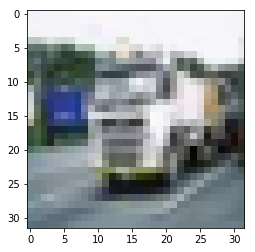

In [13]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_path = "./cifar-10-batches-py/"
batch1 = unpickle(cifar10_path + 'data_batch_1')
import matplotlib.pyplot as plt
b = batch1[b'data'][4].reshape(3, 32, 32).transpose(1,2,0).astype("uint8")
# plt.imshow(b)
b1_reshaped = batch1[b'data'].reshape(batch1[b'data'].shape[0], 3, 32, 32)
b1_reshaped[0].shape
plt.imshow(b1_reshaped[1000].transpose(1, 2, 0))
b1_reshaped[0]

In [3]:
def makeChannels(max_channel, reverse=False, num_channels=3):
    assert max_channel % 2==0
    channels = [max_channel] # Stores channels for layers 1->4
    for i in range(1,num_channels):
        channels.append(channels[i-1]//2)
    if reverse:
        channels.reverse()
        return channels
    return channels

class GeneratorNet(nn.Module):
    def __init__(self, cz=100, gf_dim=64):
        super(GeneratorNet, self).__init__()
        channels = makeChannels(4*gf_dim, reverse=True)
        self.model = nn.Sequential(
            # Project and reshape
            nn.ConvTranspose2d(cz, channels[0], 4, 1, 0, bias=False),
            A.ReLU(),
            nn.BatchNorm2d(channels[0]),
            # Conv1. (?, channels[0], 4, 4) -> (?, channels[1], 8, 8)
            nn.ConvTranspose2d(channels[0], channels[1], 4, 2, 1, bias=True),
            A.ReLU(),
            nn.BatchNorm2d(channels[1]),
            # Conv2. (?, channels[1], 8, 8) -> (?, channels[2], 16, 16)
            nn.ConvTranspose2d(channels[1], channels[2], 4, 2, 1, bias=True),
            A.ReLU(),
            nn.BatchNorm2d(channels[2]),
            # Conv3. (?, channels[2], 16, 16) -> (?, channels[3], 32, 32)
#             nn.ConvTranspose2d(channels[2], channels[3], 4, 2, 1, bias=True),
#             A.ReLU(),
#             nn.BatchNorm2d(channels[3]),
            # Conv4. (?, channels[3], 32, 32) -> (?, 3, 64, 64)
            nn.ConvTranspose2d(channels[2], 3, 4, 2, 1, bias=True),
            A.Tanh()
        )
        
    def forward(self, z):
        """
        Input: 
            - z: minibatch of 1D noise vectors/"codes"
        Shapes:
            - z: (N, C) where N is batch_size and C is channels of z.
        """
        return self.model(z)

class DiscriminatorNet(nn.Module):
    def __init__(self, gf_dim=64):
        super(DiscriminatorNet, self).__init__()
        channels = makeChannels(4*gf_dim)
        self.model = nn.Sequential(
            # Project image 
            nn.Conv2d(3, channels[0], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channels[0], channels[1], 4, 2, 1, bias=True),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(channels[1]),
            nn.Conv2d(channels[1], channels[2], 4, 2, 1, bias=True),
            nn.BatchNorm2d(channels[2]),
#             nn.Conv2d(channels[2], channels[3], 4, 1, 0, bias=True),
            nn.Conv2d(channels[2], 1, 4, 1, 0, bias=True),
            nn.Sigmoid()
#             nn.BatchNorm2d(channels[3]),
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
batch_size=32
dataset = torch.utils.data.TensorDataset(torch.from_numpy(b1_reshaped))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
torch.from_numpy(b1_reshaped).shape

torch.Size([10000, 3, 32, 32])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G=GeneratorNet(cz=100, gf_dim=64)
D=DiscriminatorNet()
gopt = optim.Adam(G.parameters())
dopt = optim.Adam(D.parameters())

criterion = nn.BCELoss(reduction='elementwise_mean')

In [18]:
mbatch_mod = 300
epoch_mod = 2
for epoch in range(5):
    for mbatch_idx, x in tqdm(enumerate(dataloader)):
        ##############################
        # Update discriminator 
        ##############################
        x = x[0]
        x = x.to(device, dtype=torch.float32)
        real_loss = criterion(D(x), torch.ones([x.shape[0], 1, 1, 1]))
        real_loss.backward()
        
        z = torch.zeros([x.shape[0], 100, 1, 1]).uniform_(0, 1)
#         import ipdb; ipdb.set_trace()
        generated_loss = criterion(D(G(z)), torch.zeros([x.shape[0], 1, 1, 1]))
        generated_loss.backward()

        dloss = real_loss.item() + generated_loss.item()

        dopt.step()
        dopt.zero_grad()
        
        ##############################
        # Update generator
        ##############################
        z = torch.zeros([x.shape[0], 100, 1, 1]).uniform_(0, 1)
        gloss = torch.Tensor([1.0]) * criterion(D(G(z)), torch.zeros([x.shape[0], 1, 1, 1]))   
        gloss.backward()
        
        gopt.step()
        gopt.zero_grad()
        
        if (mbatch_idx % mbatch_mod == 0 and mbatch_idx > 0 and epoch % epoch_mod == 0):
            print(F"Epoch: {epoch}, minibatch: {mbatch_idx}, DLoss: {dloss}, GLoss: {gloss}")

32it [00:41,  1.31s/it]

KeyboardInterrupt: 

[Parameter containing:
 tensor([[[[-4.5992e-03, -1.5774e-02,  7.0850e-03, -2.1321e-02],
           [-1.7161e-02,  1.6140e-02, -2.8499e-02,  2.2328e-02],
           [ 2.5673e-02, -1.1924e-02, -5.9561e-03,  1.8986e-02],
           [ 1.1725e-02, -3.4977e-02,  7.8257e-03, -6.5446e-03]],
 
          [[ 6.7556e-03,  1.6638e-02,  9.5296e-03, -1.2224e-02],
           [ 1.2617e-02, -1.9107e-03,  7.9660e-04, -1.8233e-02],
           [ 1.5534e-02,  2.6069e-02, -3.4175e-03, -1.9317e-03],
           [ 3.1502e-02, -2.3239e-02,  6.8758e-03,  2.7158e-02]],
 
          [[ 1.8895e-02,  1.5147e-02,  1.1320e-02, -1.4707e-02],
           [ 1.2932e-02,  5.2510e-03, -7.5130e-03,  1.0041e-02],
           [ 5.1613e-04, -5.0634e-03,  2.9348e-02,  1.8736e-02],
           [-2.0897e-03, -5.8910e-03, -9.8303e-03, -3.0375e-03]],
 
          ...,
 
          [[-4.7057e-03, -1.3848e-02,  3.3337e-03, -2.9465e-02],
           [ 3.9600e-03,  2.8464e-03, -2.3259e-02, -4.2239e-03],
           [ 4.4645e-03, -1.9886e-02,  1.

In [7]:
dl(torch.unsqueeze(torch.ones(10), dim=1), torch.unsqueeze(torch.ones(10), dim=1))

NameError: name 'dl' is not defined

In [ ]:
torch.Tensor([-1]) * torch.Tensor([3, 3, 1])